<a href="https://colab.research.google.com/github/douglasta2024/Coding-Projects/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() 

train_images = train_images.reshape(-1, 28, 28, 1).astype('float32') #-1 represents train_images.shape[0]
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
train_labels = to_categorical(train_labels, num_classes = 10)

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11490434/11490434 [==============================] - 0s 0us/step


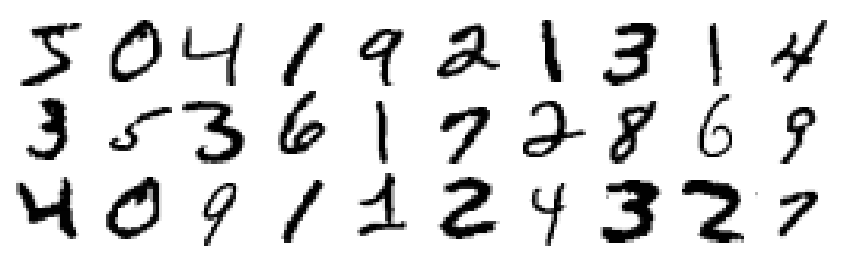

In [3]:
# PREVIEW IMAGES
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(train_images[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [4]:
# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

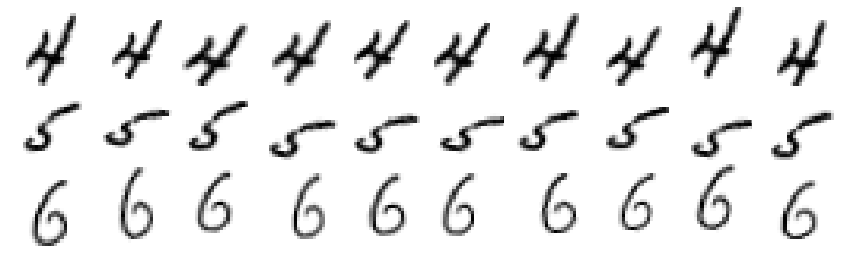

In [5]:
X_train3 = train_images[9,].reshape((1,28,28,1))
Y_train3 = train_labels[9,].reshape((1,10))
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    X_train2, Y_train2 = datagen.flow(X_train3,Y_train3).next()
    plt.imshow(X_train2[0].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
    if i==9: X_train3 = train_images[11,].reshape((1,28,28,1))
    if i==19: X_train3 = train_images[18,].reshape((1,28,28,1))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

### **Generative Model Creation**

In [6]:
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)

In [97]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(256,))) #Could try 448 for input shape. Could also change 256 to 512 to add an extra layer of neurons
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    #assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    #assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    #assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')) #Could change tanh to softmax or relu
    #assert model.output_shape == (None, 28, 28, 1)

    print(model.summary())

    return model

In [98]:
generator = generator_model()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 12544)             3211264   
                                                                 
 batch_normalization_12 (Bat  (None, 12544)            50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 7, 7, 128)        819200    
 Transpose)                                                      
                                                                 
 batch_normalization_13 (Bat  (None, 7, 7, 128)      

Image Sample Generation

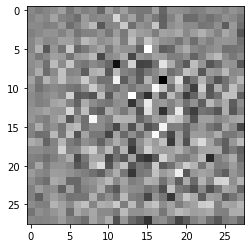

In [99]:
# Create a random noise and generate a sample
noise = tf.random.normal([1, 256])
generated_image = generator(noise, training=False)

# Visualize the generated sample
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Adversarial Network

In [100]:
def discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=(1, 1), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    print(model.summary())

    return model

In [101]:
discriminator = discriminator_model()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 28, 28, 64)        0         
                                                                 
 dropout_18 (Dropout)        (None, 28, 28, 64)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 14, 128)       204928    
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 dropout_19 (Dropout)        (None, 14, 14, 128)       0         
                                                                 
 flatten_7 (Flatten)         (None, 25088)           

Configuration

In [102]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Training

In [103]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [104]:
EPOCHS = 40
num_examples_to_generate = 16
noise_dim = 256
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [105]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Image Generation Function

In [106]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

GAN Training

In [107]:
import time
from IPython import display 

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

Digit Generation

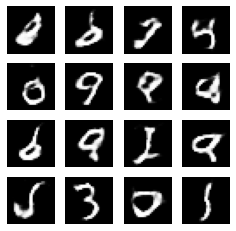

In [108]:
train(train_dataset, EPOCHS)


In [109]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

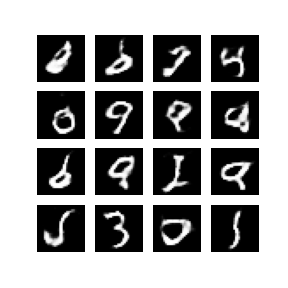

In [110]:
import PIL 
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)

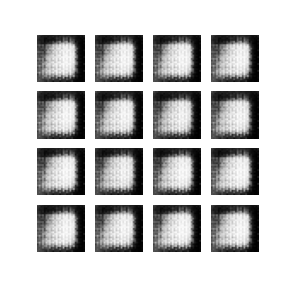

In [111]:
import glob 
import imageio 

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  
display.Image(open('dcgan.gif','rb').read())